## 📊 Exploratory Data Analysis – Top Cancer Counties
This section visualizes the top 10 counties in California with the highest estimated number of cancer incidents.

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
df = pd.read_csv("cleaned_cancer_dataset.csv")
df.head()

,Counties,Sex,Cancer,PopTot,AAIR,Cancer_Incidents
0,Alameda,Male,Prostate,4150512,91.9,3814.320528
1,Alameda,Female,Prostate,4209494,0.0,0.000000
2,Alameda,Male,Breast,4150512,1.2,49.806144
3,Alameda,Female,Breast,4209494,125.4,5278.705476
4,Alameda,Male,Lung,4150512,37.8,1568.893536


In [6]:
cancer_by_county = df.groupby("Counties")["Cancer_Incidents"].sum().reset_index()
cancer_by_county = cancer_by_county.sort_values(by="Cancer_Incidents", ascending=False)
cancer_by_county.head(10)

,Counties,Cancer_Incidents
17,Los Angeles,328954.194195
35,San Diego,126090.400276
28,Orange,116167.866615
31,Riverside,84958.205861
34,San Bernardino,76842.957563
41,Santa Clara,66480.395872
32,Sacramento,57176.611038
0,Alameda,55744.659744
6,Contra Costa,42710.638806
53,"Tulare, Fresno",34690.427642


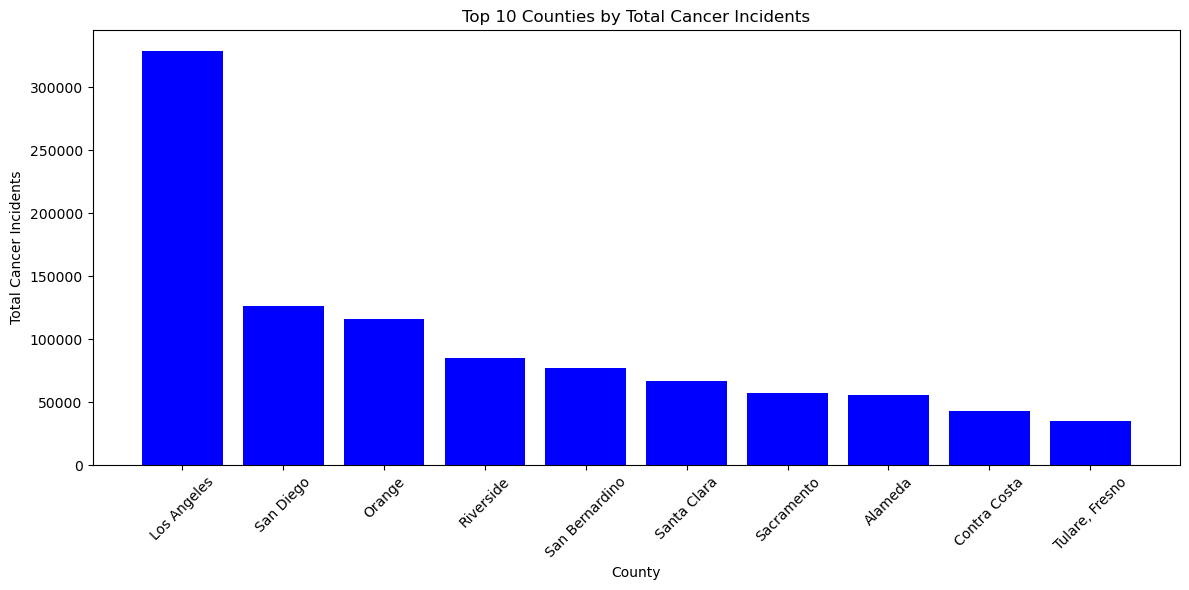

In [10]:
plt.figure(figsize=(12, 6))
plt.bar(cancer_by_county["Counties"][:10], cancer_by_county["Cancer_Incidents"][:10], color="blue")
plt.xlabel("County")
plt.ylabel("Total Cancer Incidents")
plt.title("Top 10 Counties by Total Cancer Incidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 🔬 PFAS vs Cancer Rate – Hypothesis Testing
This section explores whether higher PFAS levels are associated with increased cancer rates (AAIR) across California counties.

In [12]:
df_pfas = pd.read_csv("cleaned_pfas.csv")
df_pfas.head()

,county,gm_samp_collection_date,10:2FTS,11ClPF3OUDS,3:3FTCA,4:2FTS,5:3FTCA,6:2FTS,7:3FTCA,8:2FTS,...,PFNS,PFOA,PFODA,PFOS,PFOSA,PFPA,PFPES,PFTEDA,PFTRIDA,PFUNDCA
0,Alameda,2018-09-11,2.322092,2.066273,4.251273,7.846245,3.418426,2136.875818,5.346817,54.121071,...,1.688733,3.000000,3.283286,10.500000,3.300000,2.050000,140.359630,3.300000,3.300000,2.050000
1,Alameda,2018-11-28,2.322092,2.066273,4.251273,7.846245,3.418426,2136.875818,5.346817,54.121071,...,1.688733,2.900000,3.283286,12.000000,3.300000,2.050000,140.359630,2.000000,2.000000,2.000000
2,Alameda,2018-12-04,2.322092,2.066273,4.251273,7.846245,3.418426,2136.875818,5.346817,54.121071,...,1.688733,2.500000,3.283286,9.000000,3.300000,2.050000,140.359630,2.000000,2.000000,2.000000
3,Alameda,2019-01-02,5.168571,2.023503,2.195714,1.553516,2.744286,688.090220,2.195714,100.751923,...,6.537143,4.016667,3.844286,28.333333,79.073196,801.419744,390.941038,2.033333,2.033333,2.033333
4,Alameda,2019-01-22,5.168571,2.023503,2.195714,1.553516,2.744286,688.090220,2.195714,100.751923,...,6.537143,4.525000,3.844286,40.750000,79.073196,801.419744,390.941038,1.412557,1.461570,1.649533


In [20]:
pfas_chemicals = df_pfas.columns[2:]
df_pfas["Total_PFAS"] = df_pfas[pfas_chemicals].sum(axis=1)
pfas_by_county = df_pfas.groupby("county")["Total_PFAS"].mean().reset_index()
pfas_by_county.columns = ["County", "Avg_PFAS"]
pfas_by_county.head()

,County,Avg_PFAS
0,Alameda,2917.037213
1,Amador,153.169449
2,Calaveras,183.728452
3,Colusa,405.688091
4,Contra Costa,27737.081010


In [22]:
merged_df = pd.merge(df, pfas_by_county, how="inner", left_on="Counties", right_on="County")
merged_df.head()

,Counties,Sex,Cancer,PopTot,AAIR,Cancer_Incidents,County,Avg_PFAS
0,Alameda,Male,Prostate,4150512,91.9,3814.320528,Alameda,2917.037213
1,Alameda,Female,Prostate,4209494,0.0,0.000000,Alameda,2917.037213
2,Alameda,Male,Breast,4150512,1.2,49.806144,Alameda,2917.037213
3,Alameda,Female,Breast,4209494,125.4,5278.705476,Alameda,2917.037213
4,Alameda,Male,Lung,4150512,37.8,1568.893536,Alameda,2917.037213


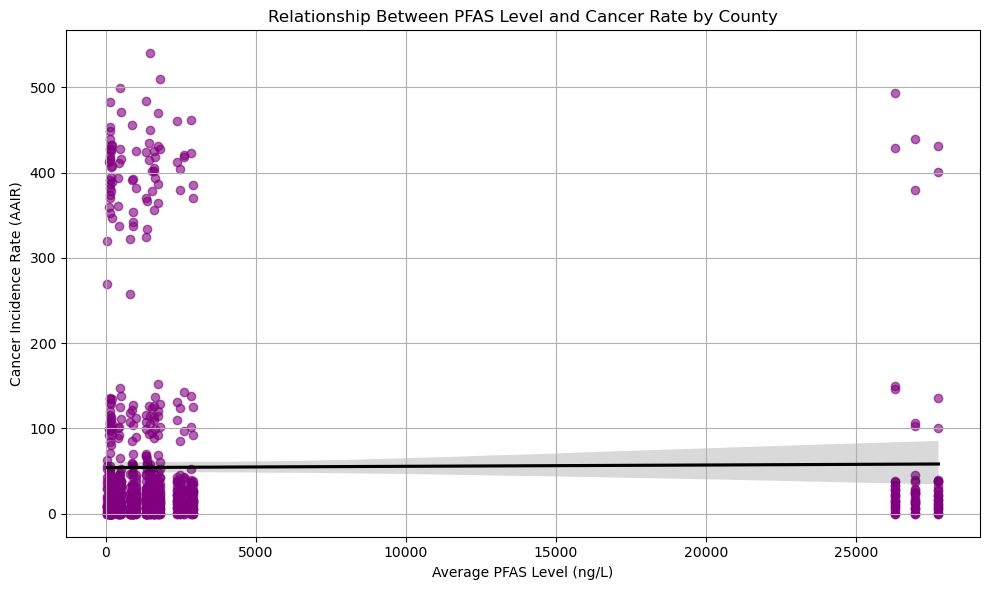

In [43]:
plt.figure(figsize=(10, 6))
sns.regplot(data=merged_df, x="Avg_PFAS", y="AAIR", scatter_kws={"alpha":0.6}, line_kws={"color":"black"}, color="purple")
plt.xlabel("Average PFAS Level (ng/L)")
plt.ylabel("Cancer Incidence Rate (AAIR)")
plt.title("Relationship Between PFAS Level and Cancer Rate by County")
plt.grid(True)
plt.tight_layout()
plt.show()

## 📉 Data Interpretation

The scatter plot shows that there is not a strong linear relationship between PFAS contamination levels and cancer incidence rates (AAIR) across California counties. The trendline is nearly flat and data points are distributed across all four corners of the graph including counties with high PFAS but low cancer rates, and vice versa. 

This suggests that PFAS levels alone do not explain cancer patterns in this dataset. Other factors such as genetics, healthcare access, income, and long-term exposure likely play a significant role.